In [39]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
words = open("names.txt", 'r').read().splitlines()
print(type(words))
words[0:8]

<class 'list'>


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [43]:
len(words)

32033

In [45]:
def stoi(c):
    if c == '.':
        return 0
    return ord(c) - ord('a') + 1
def itos(x):
    if x == 0:
        return '.'
    return chr(x+ord('a')-1) 

In [47]:
# Parameters
block_size = 5
num_neurons = 300
embedding_size = 10
vocab_size = 27
mini_batch_size = 32

In [49]:
X = []
Y = []

In [51]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
       context = [0]*block_size
       for ch in w + '.':
           ch_y = stoi(ch)
           #print(''.join(itos(c) for c in context) + ' --> ' + ch)
           X.append(context)
           Y.append(ch_y)
           context = context[1:] + [ch_y]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [53]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [55]:
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [56]:
# Network
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,embedding_size), generator=g)
W1 = torch.randn((embedding_size*block_size, num_neurons), generator=g) * (5/3) / ((embedding_size*block_size)**0.5) # 0.2
b1 = torch.randn(num_neurons, generator=g) * 0.01
W2 = torch.randn((num_neurons, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain =  torch.ones((1, num_neurons))
bnbias =  torch.zeros((1, num_neurons))
bnmean_running =  torch.zeros((1, num_neurons))
bnstd_running =  torch.ones((1, num_neurons))


parameters = [C, W1, W2, b1, b2, bngain, bnbias]

In [59]:
sum(p.nelement() for p in parameters)

24297

In [61]:
for p in parameters:
    p.requires_grad = True

The idea here is: If you want hpreact to be unit gaussian then why not take hpreact and make them gaussian
A possible downside of batch normalisation layer is that hpreact gets changed because of the elements in that batch.
This works as a regulariser and thus a good thing

In [64]:
# Training of the neural net
max_steps = 200000
lossi = []

for i in range(max_steps):
    # Mini batch works well because it gives us the approximate gradients. It is better to know the approximate gradient and take more steps
    # than to know the exact gradient and take fewer steps in that direction
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward Pass
    emb = C[Xb]
    embcat = emb.view(-1, block_size*embedding_size)

    #Linear Layer
    hpreact = embcat@W1 + b1

    #Batch Norm Layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Non-linearity
    h = torch.tanh(hpreact)
    logits = h @W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i}/{max_steps}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

0/200000:  3.3035
10000/200000:  2.3533
20000/200000:  1.9961
30000/200000:  1.8490
40000/200000:  2.3436
50000/200000:  2.1566
60000/200000:  2.0753
70000/200000:  2.2490
80000/200000:  2.1013
90000/200000:  2.0141
100000/200000:  1.9158
110000/200000:  2.0890
120000/200000:  1.8756
130000/200000:  2.1562
140000/200000:  2.1553
150000/200000:  1.8956
160000/200000:  1.7284
170000/200000:  1.7677
180000/200000:  2.2209
190000/200000:  1.9263


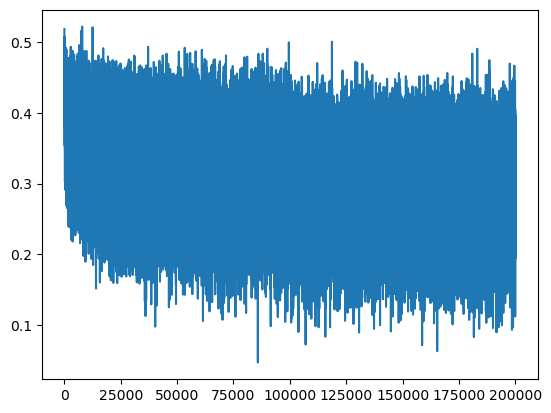

In [65]:
plt.plot(lossi)

In [66]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'test': (Xdev, Ydev),
        'val': (Xte, Yte), 
    }[split]
    emb = C[x]
    embcat = emb.view(-1, block_size*embedding_size)
    hpreact = embcat@W1 + b1 
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9270124435424805
val 2.030639171600342


In [76]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    context = [0] * block_size
    out = []
    while True:
        emb = C[torch.tensor(context)] 
        hpreact = emb.view(-1, block_size*embedding_size)@W1 + b1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos(i) for i in out))

chrisha
abbil
khierre
reity
skahman
jazon
nadelynn
jarqui
nelia
archaiir
kaleigh
hamon
catelinn
sulilea
jadii
waje
madiaryn
kalie
pirsle
edde


In [19]:
# Results 

# At the beginning
# train 2.1877903938293457
# val 2.2158210277557373

# After fixing the initial loss
# train 1.9865397214889526
# val 2.0994210243225098

# After fixing tanh saturation by manually setting it to 0.2
# train 1.9122042655944824
# val 2.0434210300445557

# After fixing tanh saturation after using gain/fan_in
# train 1.8737958669662476
# val 2.0411834716796875

# After batch norm
# train 1.926900029182434
# val 2.0273077487945557
